In [1]:
# coding: utf-8
import matplotlib.pyplot as plt

import datetime
import pandas as pd
import quantstats as qs
from pathlib import Path
import degiro_wrapper as dw

qs.extend_pandas()
plt.style.use("ggplot")

CONFIG_DIR = "/Users/mmngreco/github/mmngreco/degiro-wrapper/credentials"
ISIN_CASH = dw.conventions.ISIN_CASH

user_data = dw.api_methods.get_login_data(config=CONFIG_DIR)
path = Path(r"./assets/").expanduser().absolute()
if not path.exists():
    path.mkdir()

date_start = "20191001"
date_end = datetime.datetime.today()
calendar = pd.date_range(start=date_start, end=date_end, freq="B")

# TODO : Add early stop to dowload only new files
dw.api_methods.download_positions(
    calendar=calendar,
    path=path,
    data=user_data,
    filename_template="pos_%Y%m%d",
)

# =============================================================================
positions_raw_df = dw.preprocess.positions_xls_to_df(
    path, isin_cash=ISIN_CASH
)
cleaned_data = dw.preprocess.positions_raw_to_clean(positions_raw_df)

amount_df, prices_df, shares_df, nav_df, rets_df = cleaned_data
prices_df

100%|██████████| 139/139 [00:00<00:00, 11071.18it/s]


ISIN,LU0908500753,LU1959429272
date,,
2020-03-18,NaN,NaN
2020-03-19,NaN,NaN
2020-03-20,NaN,NaN
2020-03-23,NaN,NaN
2020-03-24,NaN,NaN
2020-03-25,129.48,NaN
2020-03-26,131.82,NaN
2020-03-27,128.03,NaN
2020-03-30,129.67,NaN


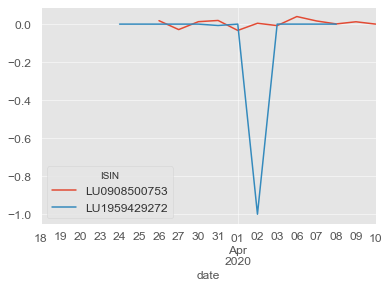

In [2]:
# =============================================================================
# Cashflows

path_account = dw.api_methods.download_cashflows(
    user_data, date_start, date_end, path
)
cashflows_df, cashflows_external_df = dw.preprocess.generate_cashflows(
    path_account=path_account, isin_cash=ISIN_CASH
)

# ??? : What means ss and why the following is needed
cashflows_ss = cashflows_df.drop(columns=ISIN_CASH).sum(axis=1)
cashflows_total_ss = (
    cashflows_external_df.set_index("date")["amount"]
    .reindex(cashflows_ss.index, fill_value=0.0)
    .add(cashflows_ss)
)

# =============================================================================
# ### Compute cash returns

cash_calendar = cashflows_total_ss.index
for today, yesterday in zip(cash_calendar[1:], cash_calendar):
    cash_today = amount_df.loc[today, ISIN_CASH]
    cash_yesterday = amount_df.loc[yesterday, ISIN_CASH]

    flows = cashflows_total_ss.loc[today]

    rets_df.loc[today, ISIN_CASH] = (cash_today - flows) / cash_yesterday - 1

# =============================================================================
# Compute performance

weights_df = amount_df.div(amount_df.sum(axis=1), axis="index").shift(1)
weights_df = weights_df.rename(columns={ISIN_CASH: "Cash"})

rets_df.plot();

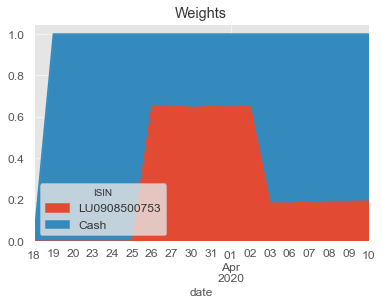

In [3]:
weights_df.plot.area(title="Weights");

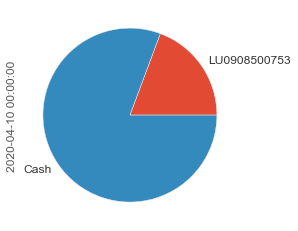

In [4]:
weights_df.tail(1).T[weights_df.index[-1]].plot.pie();

pf_returns_ss = (rets_df * weights_df).dropna(how="all").sum(axis=1)
pf_equity_ss = pf_returns_ss.add(1).cumprod().sub(1)
# qs.reports.full(returns=pf_returns_ss, benchmark="^IBEX")